In [1]:
import os, sys, glob, time, subprocess, time
import numpy as np
import healpy as hp
from astropy.table import Table
from astropy.io import fits
import fitsio

#- Some of these are imported just to establish versions
#- but aren't used in the notebook itself
import desisim
import desispec.io
from desispec.scripts import pipe_prod
import desitarget.io
import desimodel.io
import desimodel.footprint
import desisurvey
import surveysim
import specsim
#from surveysim.util import add_calibration_exposures
import desiutil.depend
import specter
import redrock

%pylab inline

print("Starting at {}".format(time.asctime()))
start_time = time.time()

Populating the interactive namespace from numpy and matplotlib
Starting at Fri Jan 19 07:42:23 2018


In [2]:
# New imports
import glob

In [3]:
print('Starting at {}'.format(time.asctime()))
print(os.environ['DESIMODULES'])
deps = dict()
desiutil.depend.add_dependencies(deps)
for codename, version in desiutil.depend.iterdep(deps):
    print('  {:10s} {}'.format(codename, version))

Starting at Fri Jan 19 07:42:23 2018
/global/common/cori/contrib/desi/desiconda/current/code/desimodules/master
  python     3.5.3
  numpy      1.11.3
  scipy      0.19.0
  astropy    1.3.3
  yaml       3.12
  matplotlib 2.0.2
  fitsio     0.9.11
  healpy     1.10.3
  desiutil   1.9.9.dev596
  desispec   0.17.1.dev2029
  desitarget 0.17.1.dev1372
  desimodel  0.9.1.dev318
  desisim    0.23.0.dev1273
  desisurvey 0.10.1.dev637
  specter    0.8.2.dev442
  speclite   0.5
  specsim    0.12dev764.dev764
  surveysim  0.9.0.dev299
  redrock    0.7.0.dev280


In [4]:
#basedir = os.path.join(os.environ['SCRATCH'], 'desi', 'dev', 'end2end')
basedir = '/project/projectdirs/desi/datachallenge/reference_runs/17.12/'   # For my testing
surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
targetdir = os.path.join(basedir, 'targets')
fibassigndir = os.path.join(basedir, 'fiberassign')
minitestdir = os.getcwd()
desimodules_version = os.path.basename(os.environ['DESIMODULES'])

os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD'] = 'mini'
os.environ['SPECPROD'] = 'mini'

reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
os.environ['DESI_SPECTRO_DATA'] = simdatadir

#

os.makedirs(surveydir, exist_ok=True)
os.makedirs(targetdir, exist_ok=True)
os.makedirs(fibassigndir, exist_ok=True)
os.makedirs(reduxdir, exist_ok=True)
os.makedirs(simdatadir, exist_ok=True)

if 'csh' in os.environ['SHELL']:
    envcmd = "source /project/projectdirs/desi/software/desi_environment.csh {}".format(desimodules_version)
    envcmd += """
set basedir = ${SCRATCH}/desi/dev/end2end
setenv DESISURVEY_OUTPUT ${basedir}/survey
setenv DESI_SPECTRO_REDUX ${basedir}/spectro/redux
setenv DESI_SPECTRO_SIM ${basedir}/spectro/sim
setenv SPECPROD mini
setenv PIXPROD mini
setenv DESI_SPECTRO_DATA ${DESI_SPECTRO_SIM}/${PIXPROD}
"""
else:
    envcmd = "source /project/projectdirs/desi/software/desi_environment.sh {}".format(desimodules_version)
    envcmd += """
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}
"""
print('To recreate this environment from a login terminal:\n')
print(envcmd)

To recreate this environment from a login terminal:

source /project/projectdirs/desi/software/desi_environment.sh master
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}



In [5]:
# New dir to define and make
qadir = desispec.io.qaprod_root()
os.makedirs(qadir, exist_ok=True)
qadir

'/project/projectdirs/desi/datachallenge/reference_runs/17.12/spectro/redux/mini/QA'

## QA

### QA without needing the Truth

In [6]:
glob.glob(qadir+'/skyresid_prod_gauss*')

[]

In [7]:
qant_logname = os.path.join(qadir, 'qa_notruth.log')

In [8]:
# Generate the QA (if it doesn't exist already)
with open(qant_logname, 'w') as logfile:
    
    if os.path.exists(qadir+'/'+os.environ['SPECPROD']+'_qa.json'):
        print("Skipping generating full prod QA file")
    else:
        # Generate yaml files and figures (~30min)
        cmd = "desi_qa_prod --make_frameqa=3 --clobber"  
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0

        # Slurp (fast)
        cmd = "desi_qa_prod --slurp"  
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0
    
    # Skyresid (~25min for the two)
    if len(glob.glob(qadir+'/skyresid_prod_dual*')) == 3:
        print("Skipping generating SkyResid figures")
    else:
        cmd = "desi_qa_skyresid --prod"  
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0
        #pass
    if len(glob.glob(qadir+'/skyresid_prod_gauss*')) == 3:
        print("Skipping generating SkyResid Gaussianity figures")
    else:    
        cmd = "desi_qa_skyresid --gauss"  
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0
    
    # HTML
    cmd = "desi_qa_prod --html"
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
    assert err == 0
    
# Time me
print("Done with QA without truth at {}".format(time.asctime()))
qa1_time = time.time() - start_time
print("That took {:.1f} minutes".format(qa1_time/60))

Done with QA without truth at Fri Jan 19 08:24:47 2018
That took 42.4 minutes


### Check

In [9]:
# JSON file
prod_qa = desispec.io.qa.load_qa_prod(qadir+'/'+os.environ['SPECPROD']+'_qa')
assert isinstance(prod_qa, dict)
assert len(prod_qa.keys()) == 4
# PNGs
assert len(glob.glob(qadir+'/skyresid_prod_dual*')) == 3
assert len(glob.glob(qadir+'/skyresid_prod_gauss*')) == 3
# HTML
assert os.path.exists(qadir+'/qa-toplevel.html')

INFO:qa.py:212:load_qa_prod: Loading QA prod file: /project/projectdirs/desi/datachallenge/reference_runs/17.12/spectro/redux/mini/QA/mini_qa.json


### Show

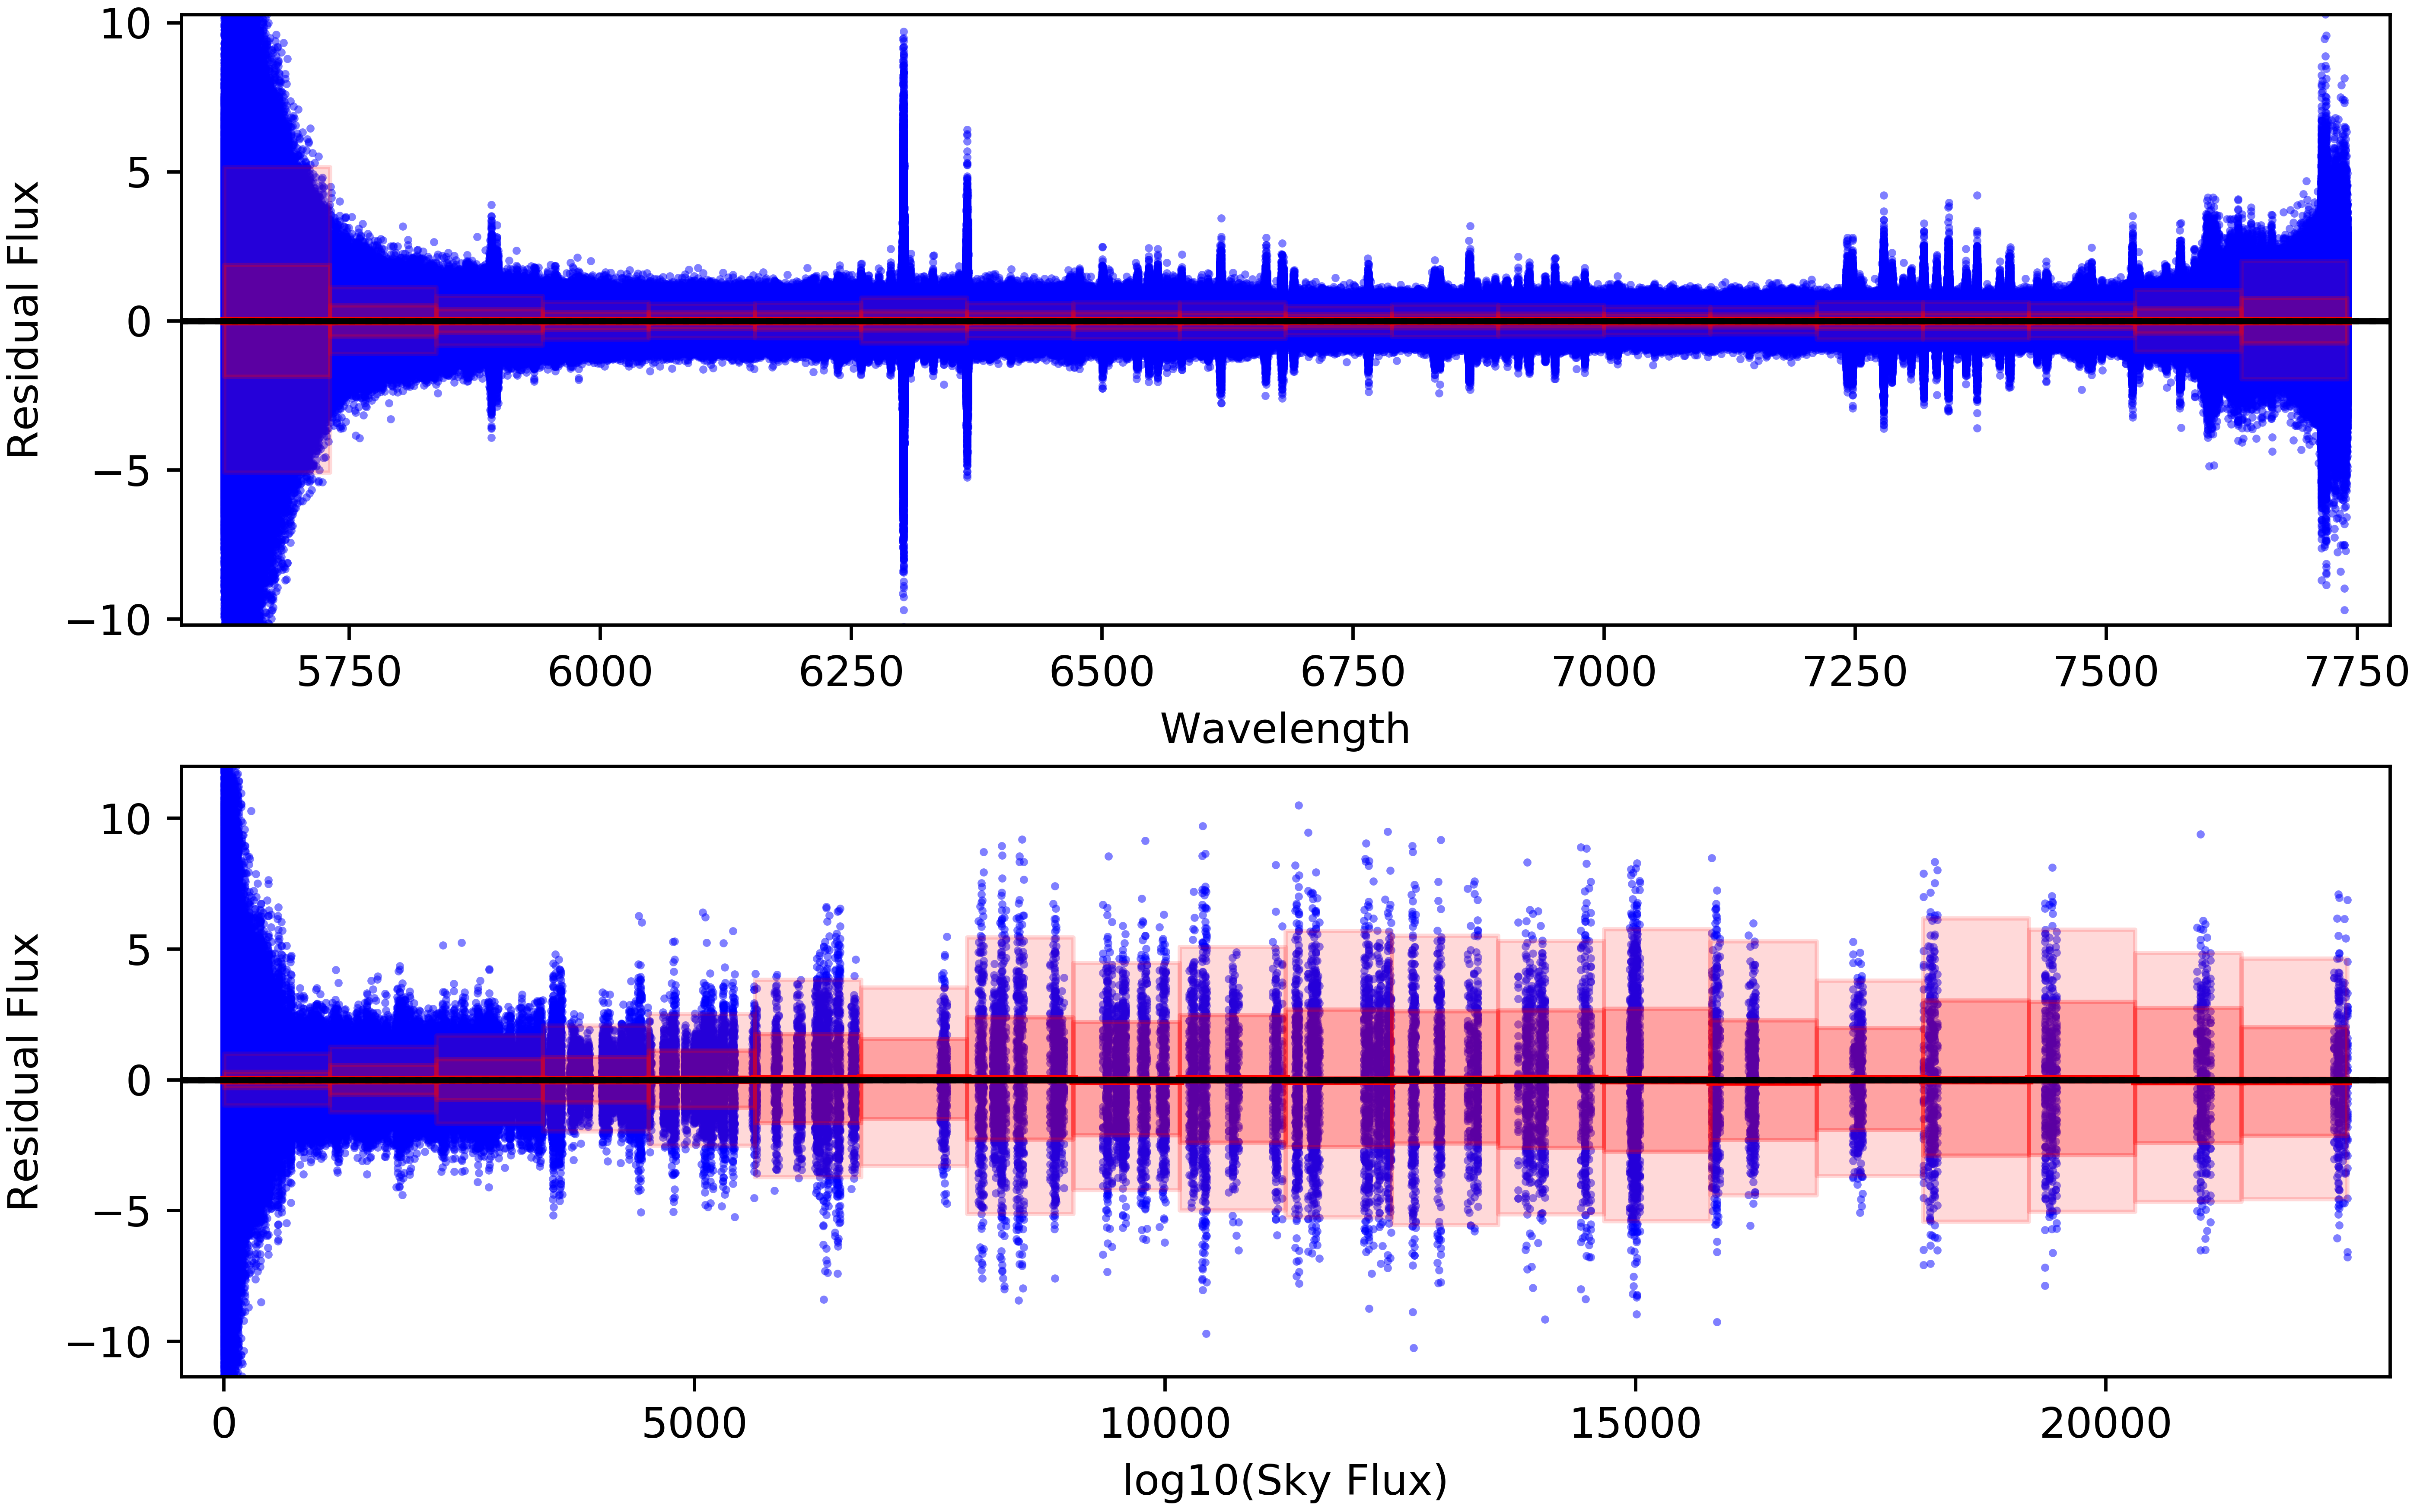

In [10]:
from IPython.display import Image
Image(filename=qadir+'/skyresid_prod_dual_r.png') 

### QA with the Truth

In [11]:
qat_logname = os.path.join(qadir, 'qa_truth.log')

In [12]:
with open(qat_logname, 'w') as logfile:

    if len(glob.glob(qadir+'/QA_s2n_*')) == 10:
        print("S/N figures already exist")
    else:
        # S/N (~7min)
        cmd = "desi_qa_s2n"  
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0
    
    # zfind (~2min)
    if (len(glob.glob(qadir+'/QA_zfind_*')) == 6) and os.path.exists(qadir+'/QA_dzsumm.png'):
        print("zfind figures already exist")
    else:
        cmd = "desi_qa_zfind"  
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0
    
    # HTML
    cmd = "desi_qa_prod --html"
    err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
    assert err == 0
    
# Time me
print("Done with QA with truth at {}".format(time.asctime()))
qa2_time = time.time() - start_time
print("That took {:.1f} additional minutes".format((qa2_time-qa1_time)/60))

Done with QA with truth at Fri Jan 19 08:32:01 2018
That took 7.2 additional minutes


### Check

In [13]:
assert len(glob.glob(qadir+'/QA_s2n_*')) == 10
assert len(glob.glob(qadir+'/QA_zfind_*')) == 6
assert os.path.exists(qadir+'/QA_dzsumm.png')

### Show

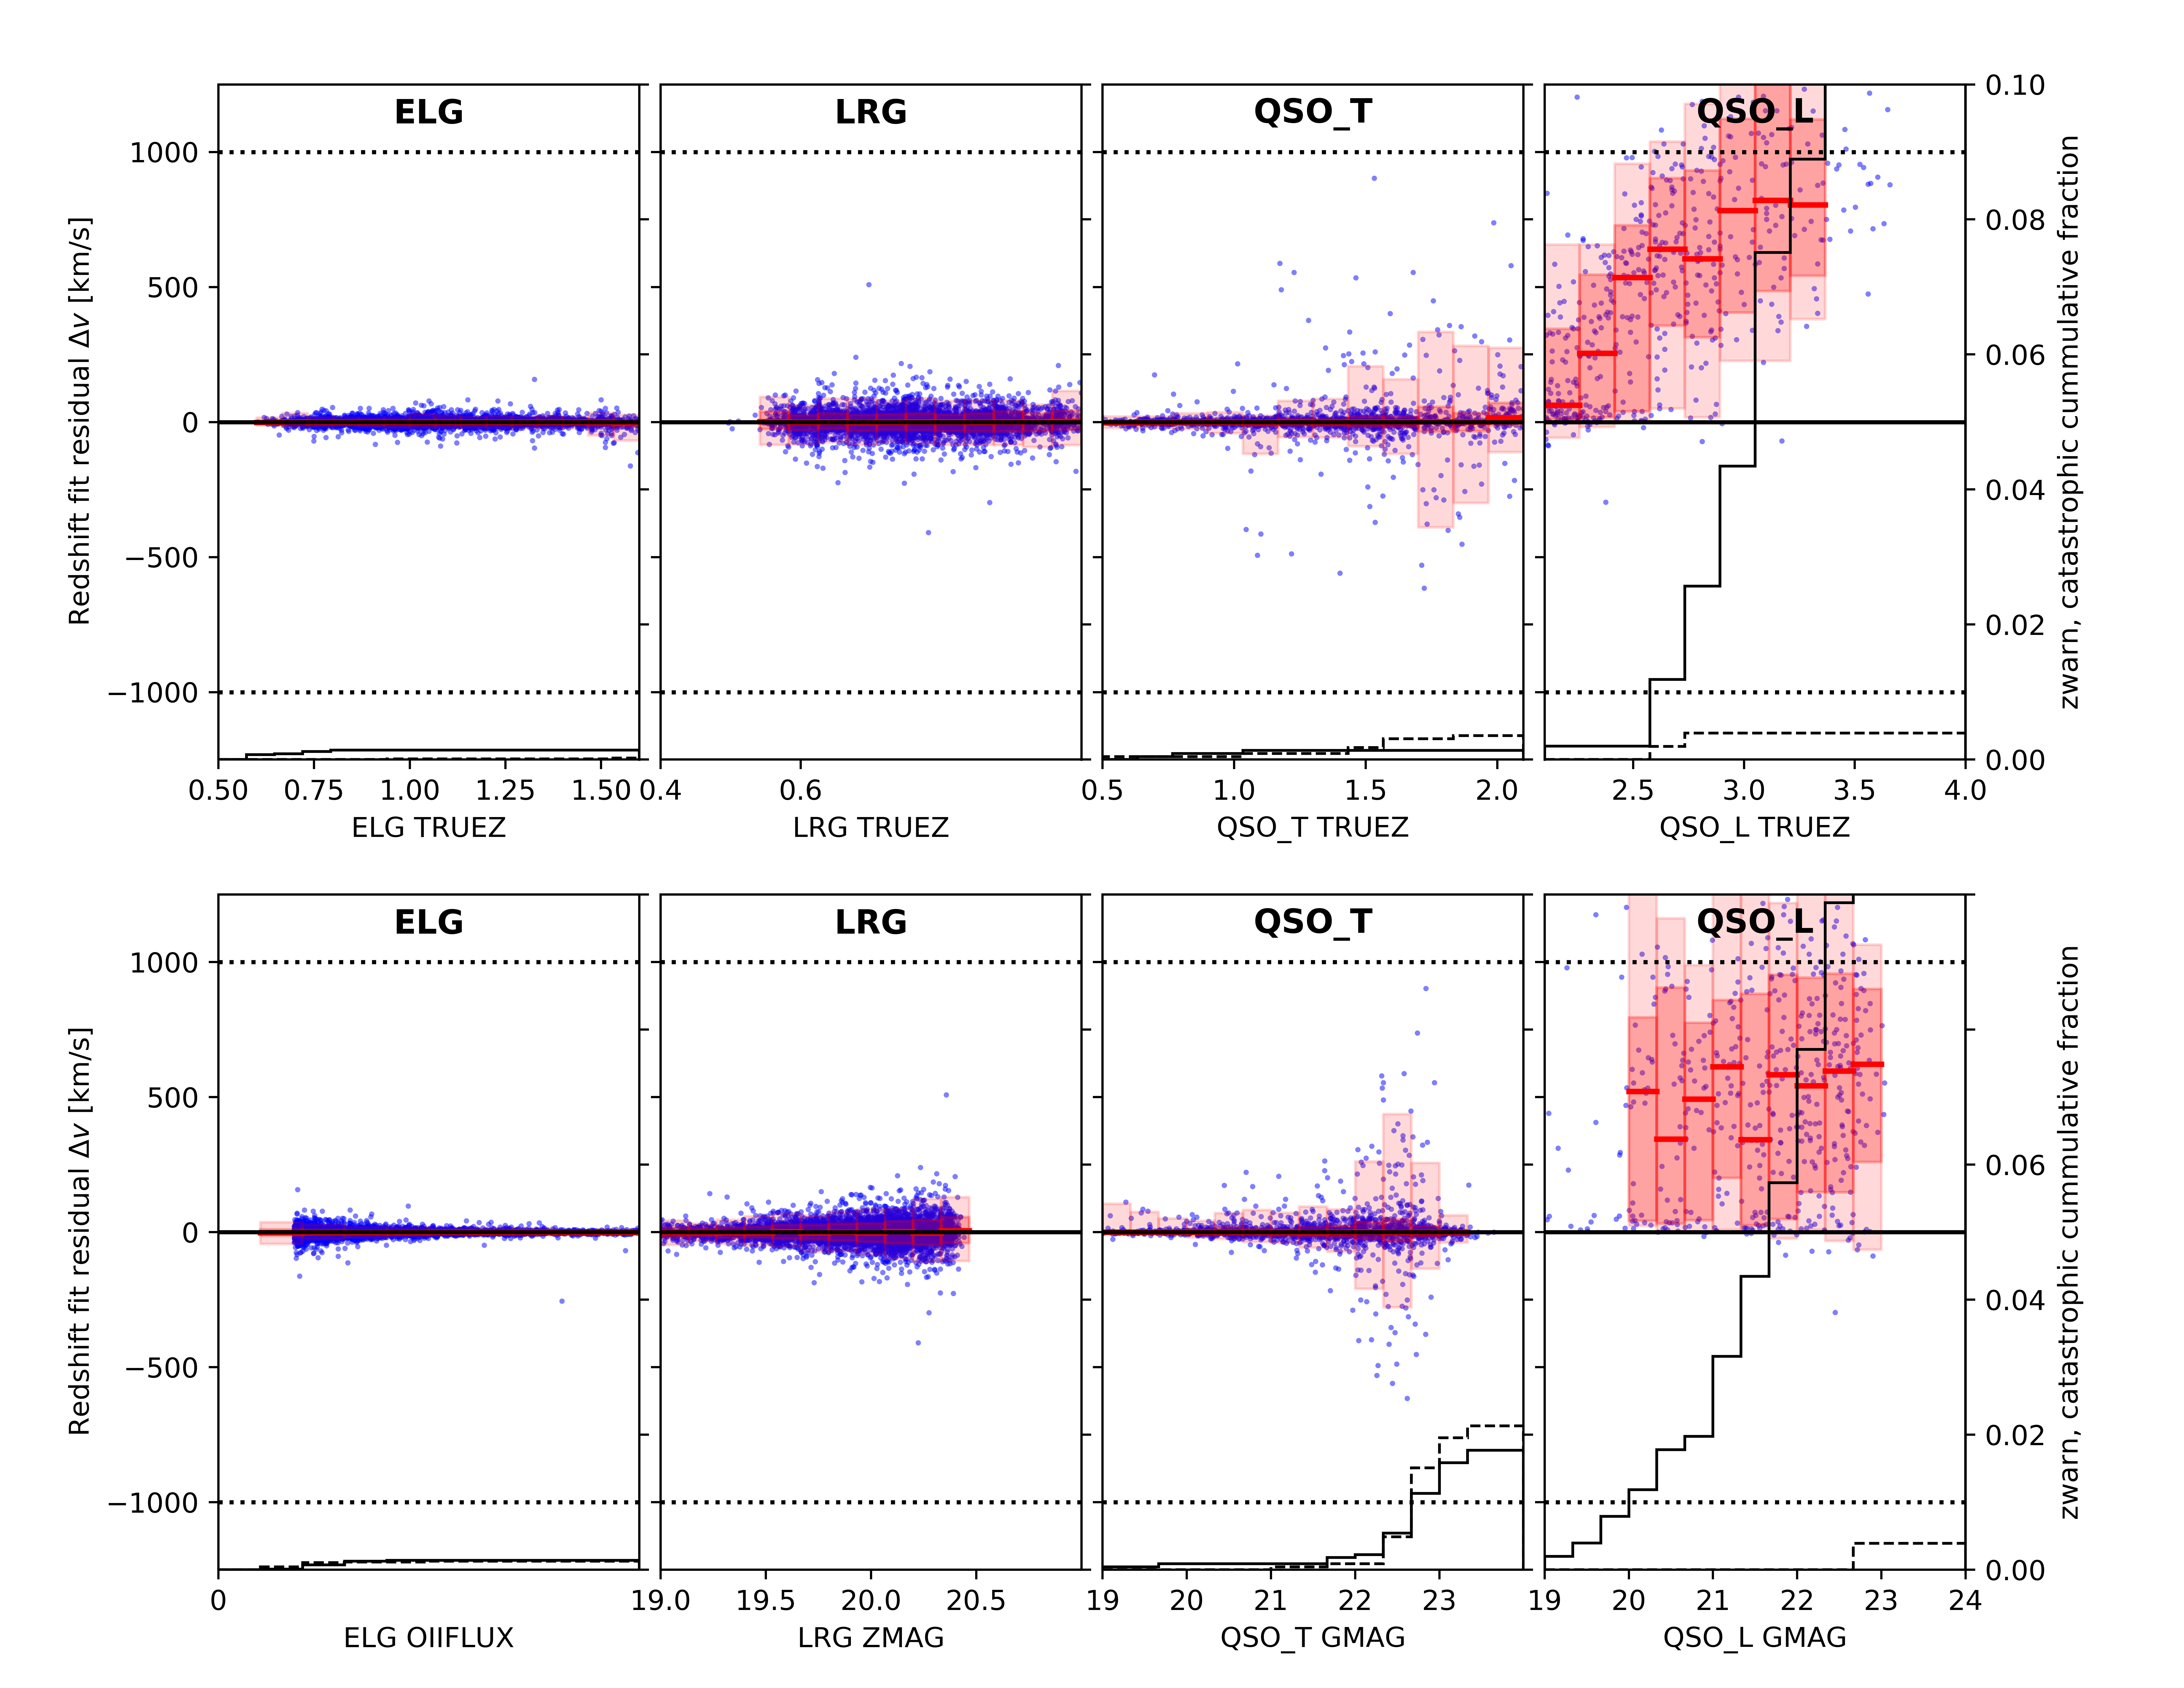

In [14]:
Image(filename=qadir+'/QA_dzsumm.png') 

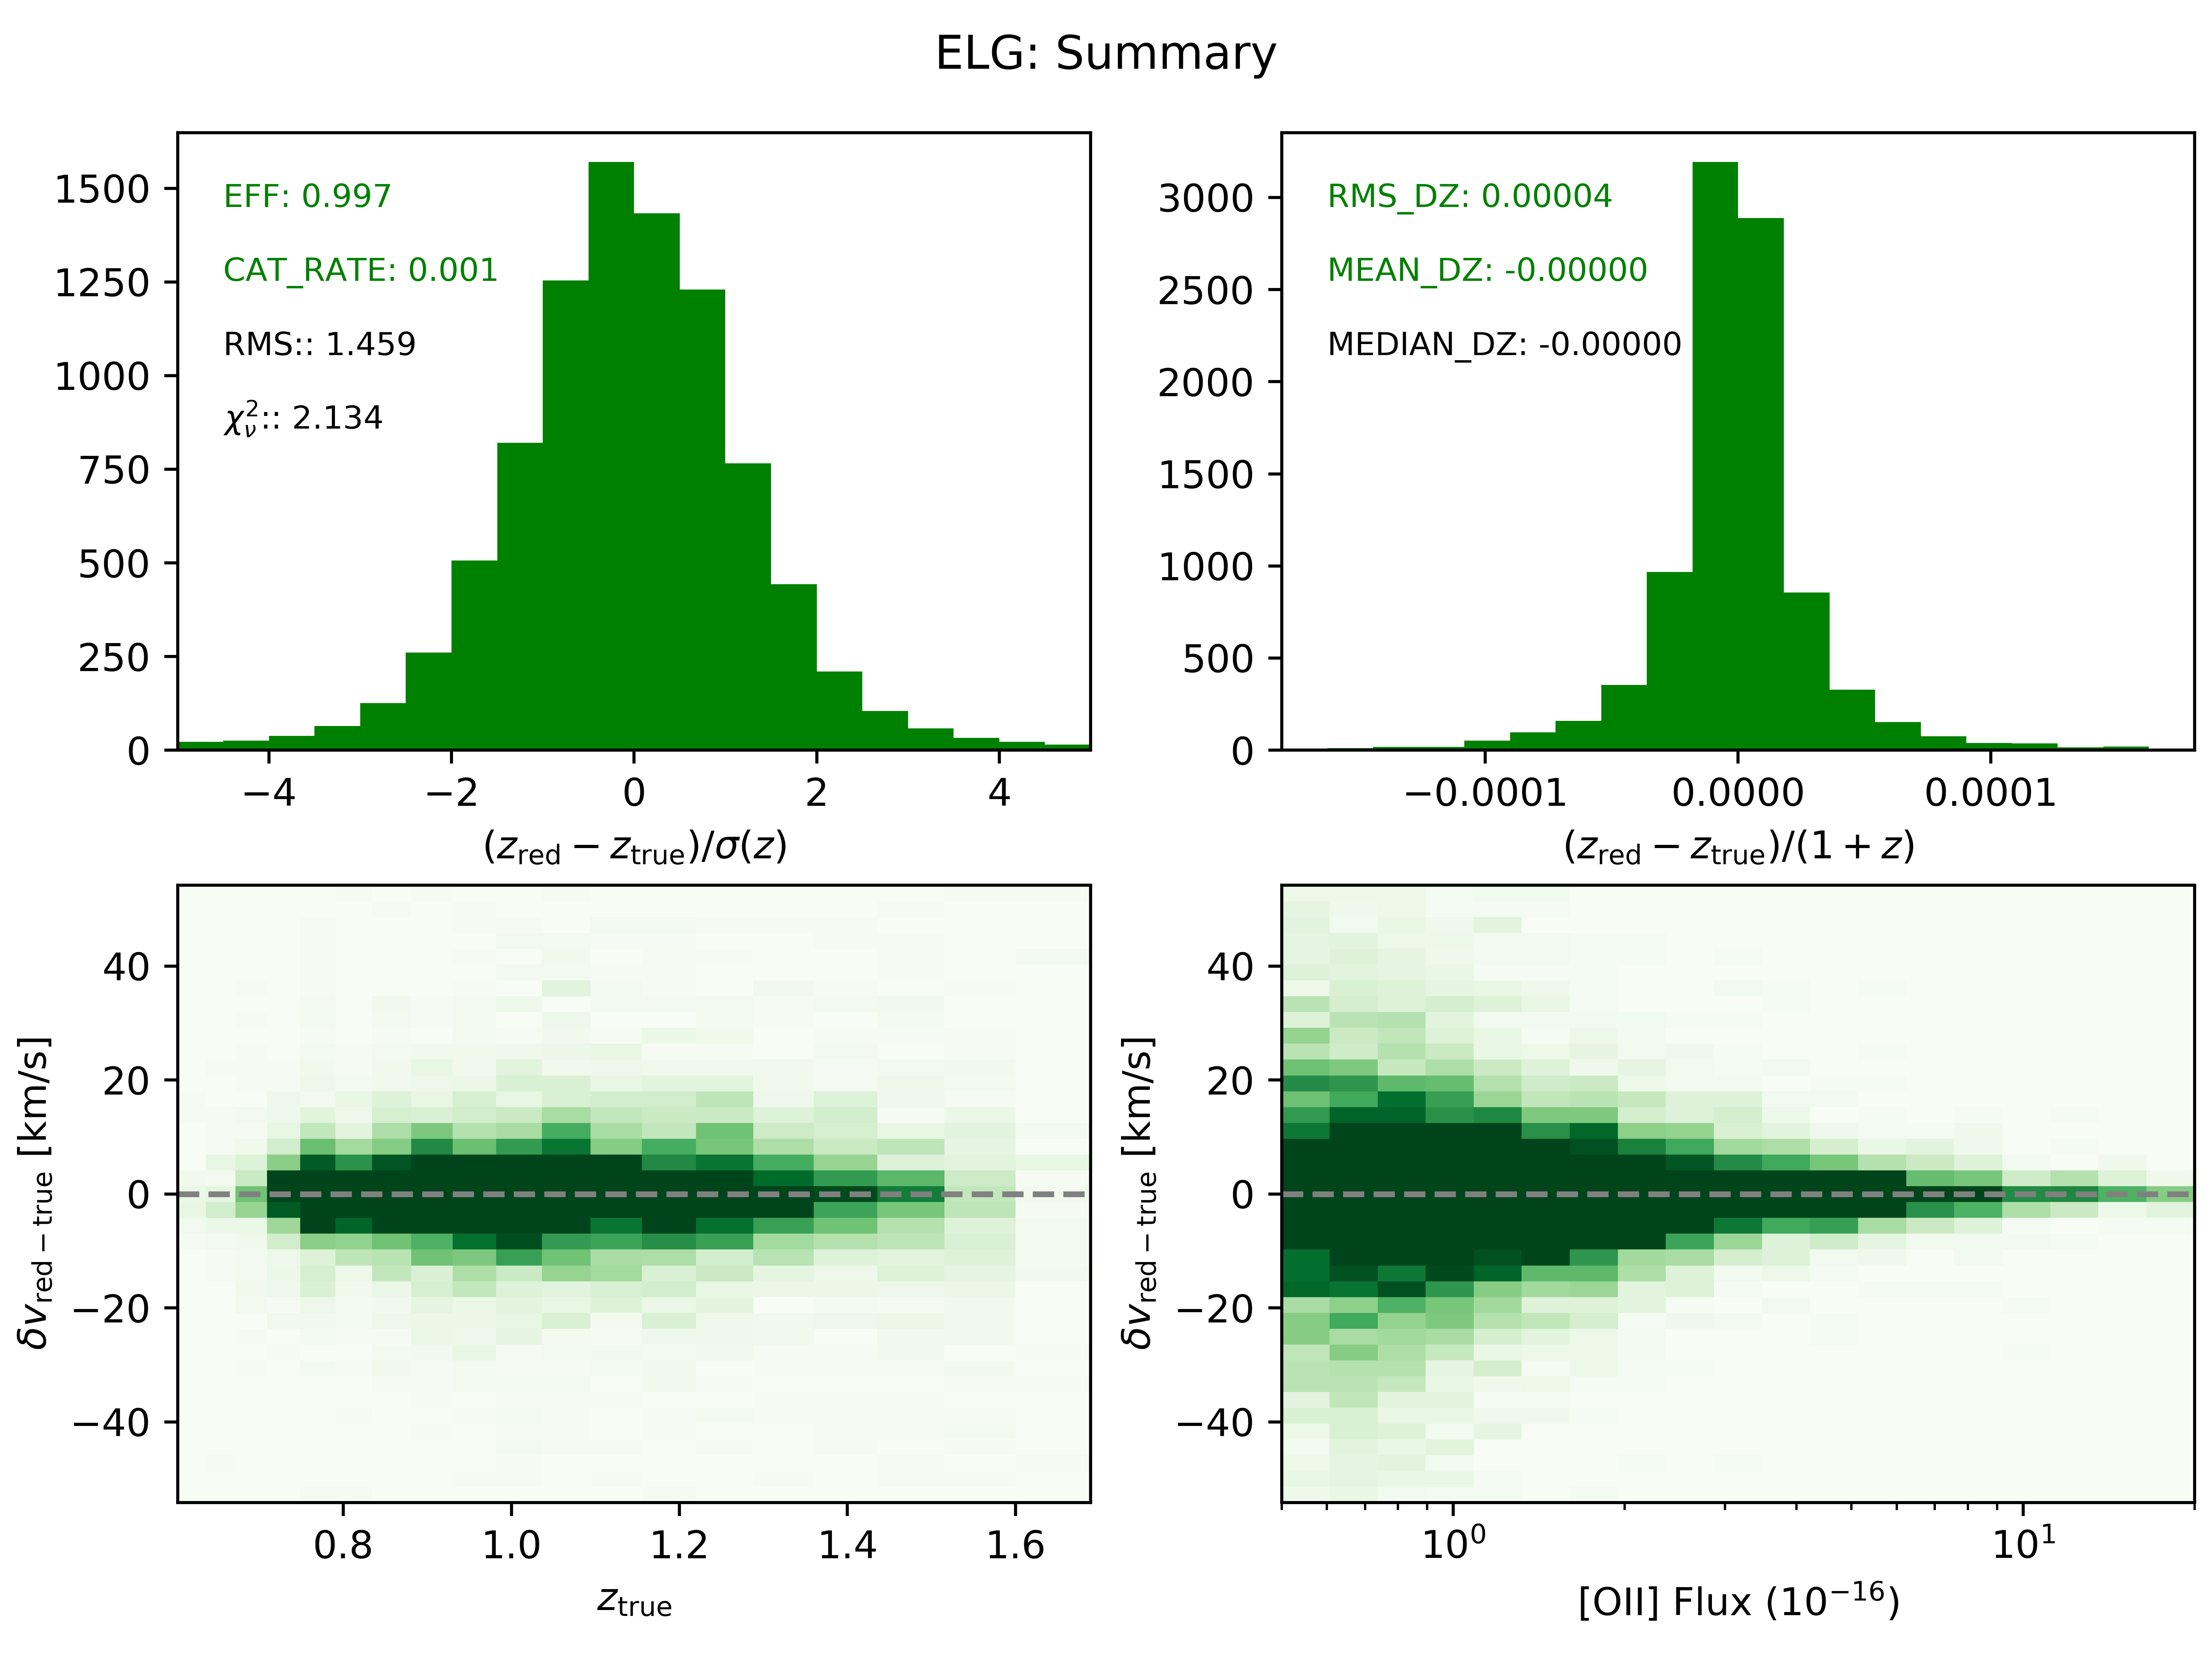

In [15]:
Image(filename=qadir+'/QA_zfind_ELG.png') 

## End

In [16]:
print("Done done at {}".format(time.asctime()))
run_time = time.time() - start_time
print("That took {:.1f} minutes".format(run_time/60))

Done done at Fri Jan 19 08:32:01 2018
That took 49.6 minutes
